# Time Series LSTM model 

- Differencing 으로 Trend 제거  
- train / test split
- feature scaling  
- supervised learning dataset 생성  
- inverse transform  
- 예측한 difference 를 원래의 시계열로 환원  
- 시각화

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
import tensorflow as tf

- dataset 의 Month column 을 datetime 으로 변환

date_parser : 문자열 열의 시퀀스를 datetime 인스턴스의 배열로 변환하는 데 사용할 함수 지정

In [2]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [3]:
df = pd.read_csv("datasets/shampoo-sales.csv", index_col='Month', date_parser=parser)
df.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


<AxesSubplot:xlabel='Month'>

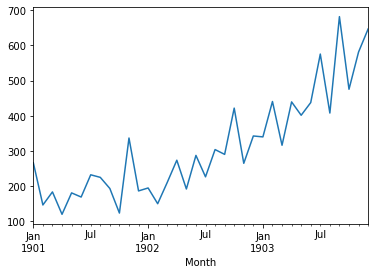

In [4]:
df['Sales'].plot()

- trend 를 제거하여 stationary 한 시계열 생성. model 은 difference를 학습.

In [5]:
differenced = df.diff().dropna()
differenced.head()

,Sales
Month,
1901-02-01,-120.1
1901-03-01,37.2
1901-04-01,-63.8
1901-05-01,61.0
1901-06-01,-11.8


In [6]:
differenced.shape

(35, 1)

### train/test split
- train : 23 개월
- test : 12 개월

In [7]:
train = np.array(differenced[:-12]).reshape(-1, 1)
test  = np.array(differenced[-12:]).reshape(-1, 1)
train.shape, test.shape

((23, 1), (12, 1))

### feature scaling

In [8]:
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

## Supervised Learning dataset 작성

In [9]:
def windowed_dataset(series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [10]:
window_size = 1
batch_size = 6

In [11]:
train_ds = windowed_dataset(train_scaled, window_size, batch_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [12]:
test_ds = windowed_dataset(test_scaled, window_size, len(test_scaled))
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [13]:
for x, y in train_ds:
    print(x.numpy().shape)
    print(y.numpy().shape)
    break

(6, 1, 1)
(6, 1)


In [14]:
for x, y in test_ds:
    print(x.numpy().shape)
    print(y.numpy().shape)
    break

(11, 1, 1)
(11, 1)


- model 생성

In [15]:
model = Sequential([
    tf.keras.layers.LSTM(20, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(train_ds, epochs=500)

Epoch 1/500
4/4 [==============================] - 2s 192ms/step - loss: 0.2775
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2667
Epoch 3/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2563
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.2463
Epoch 5/500
4/4 [==============================] - 0s 998us/step - loss: 0.2367
Epoch 6/500
4/4 [==============================] - 0s 997us/step - loss: 0.2274
Epoch 7/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2185
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2098
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 0.2014
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0.1932
Epoch 11/500
4/4 [==============================] - 0s 998us/step - loss: 0.1852
Epoch 12/500
4/4 [==============================] - 0s 998us/step - loss: 0.1774
Epoch 13/500
4/4 [==============================] -

4/4 [==============================] - 0s 997us/step - loss: 0.0346
Epoch 105/500
4/4 [==============================] - 0s 997us/step - loss: 0.0343
Epoch 106/500
4/4 [==============================] - 0s 998us/step - loss: 0.0340
Epoch 107/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 108/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 109/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 110/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0331
Epoch 111/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 112/500
4/4 [==============================] - 0s 997us/step - loss: 0.0326
Epoch 113/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 114/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0323
Epoch 115/500
4/4 [==============================] - 0s 998us/step - loss: 0.0321
Epoch 116/500
4/4 [=========================

4/4 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 307/500
4/4 [==============================] - 0s 997us/step - loss: 0.0290
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 311/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 312/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 313/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0290
Epoch 314/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 315/500
4/4 [==============================] - 0s 996us/step - loss: 0.0290
Epoch 316/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 317/500
4/4 [==============================] - 0s 997us/step - loss: 0.0289
Epoch 318/500
4/4 [=============================

In [16]:
y_hat = model.predict(test_ds)
y_hat.shape

(11, 1)

- denormalize

In [17]:
y_hat = sc.inverse_transform(y_hat)
y_hat

array([[  21.592644 ],
       [ -59.698982 ],
       [  84.065605 ],
       [ -80.71852  ],
       [  43.552376 ],
       [  -5.9463196],
       [ -94.87051  ],
       [  97.586174 ],
       [-242.2956   ],
       [ 106.1066   ],
       [ -64.51306  ]], dtype=float32)

- model 은 difference를 예측하도록 학습하였으므로, 원래의 시계열로 변환 
- 당일 value = 전일 value + difference(y_hat) 이므로,  
  `prediction = series[-len(yhat)-1:-1] + yhat`  
  `true_vales = series[-len(yhat):]`

In [18]:
series = df.values

In [19]:
prediction = series[-len(y_hat)-1:-1]  + y_hat
true_values = series[-len(y_hat):]

In [21]:
for i in range(len(prediction)):
    print(f'Predicted={prediction[i][0]:.2f}, Expected={true_values[i][0]:.2f}')

Predicted=361.29, Expected=440.40
Predicted=380.70, Expected=315.90
Predicted=399.97, Expected=439.30
Predicted=358.58, Expected=401.30
Predicted=444.85, Expected=437.40
Predicted=431.45, Expected=575.50
Predicted=480.63, Expected=407.60
Predicted=505.19, Expected=682.00
Predicted=439.70, Expected=475.30
Predicted=581.41, Expected=581.30
Predicted=516.79, Expected=646.90


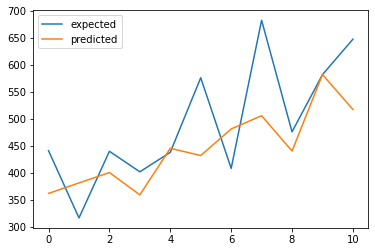

In [22]:
plt.plot(true_values, label='expected')
plt.plot(prediction, label='predicted')
plt.legend()